<a href="https://colab.research.google.com/github/reinereng/DNC/blob/main/Desafio_05_Dataset%20para%20a%20modelagem%20de%20dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATASET PARA MODELAGEM DE DADOS**

Desafio 05 do curso de Formação de Dados da DNC. O foco desta atividade é aplicar os conhecimentos de Limpeza e organização de dados (*data cleaning* & *data wrangling*)

---
## **Contexto**

Uma empresa do ramo de e-commerce contratou você para levantar os indicadores de
recência, frequência e ticket médio (RFM) dos seus clientes. A saber RFM:
* **R (Recency):** Tempo que o cliente realizou a última compra (em dias)
* **F (Frequency)**: Quantidade de compras realizadas pelo cliente
* **M (Monetary):** Valor do ticket médio gasto pelo cliente

onde ticket médio = média do total gasto por pedido para cada cliente.

**OBJETIVO:** construir um código em Python que gera um output também csv, porém contendo apenas a identificação do cliente e métricas RFM

In [ ]:
!pip install pandas-profiling
!pip install sidetable

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sidetable
import pandas_profiling
import missingno as msno
from ipywidgets import interact, widgets

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

In [46]:
# Banco de dados do projeto
df = pd.read_csv('/content/drive/MyDrive/Repositório Git/DNC/Desafio 05/data.csv', encoding='latin-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [23]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [21]:
# Crie o relatório
profile = pandas_profiling.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **LIMPEZA DOS DADOS - DATA CLEANING**

## *Dados Faltantes*
Remoção de dados faltantes do cliente, são mais de 135.000 dados - (25%). Sugestão: Averiguar os motivos desses dados estarem faltando.

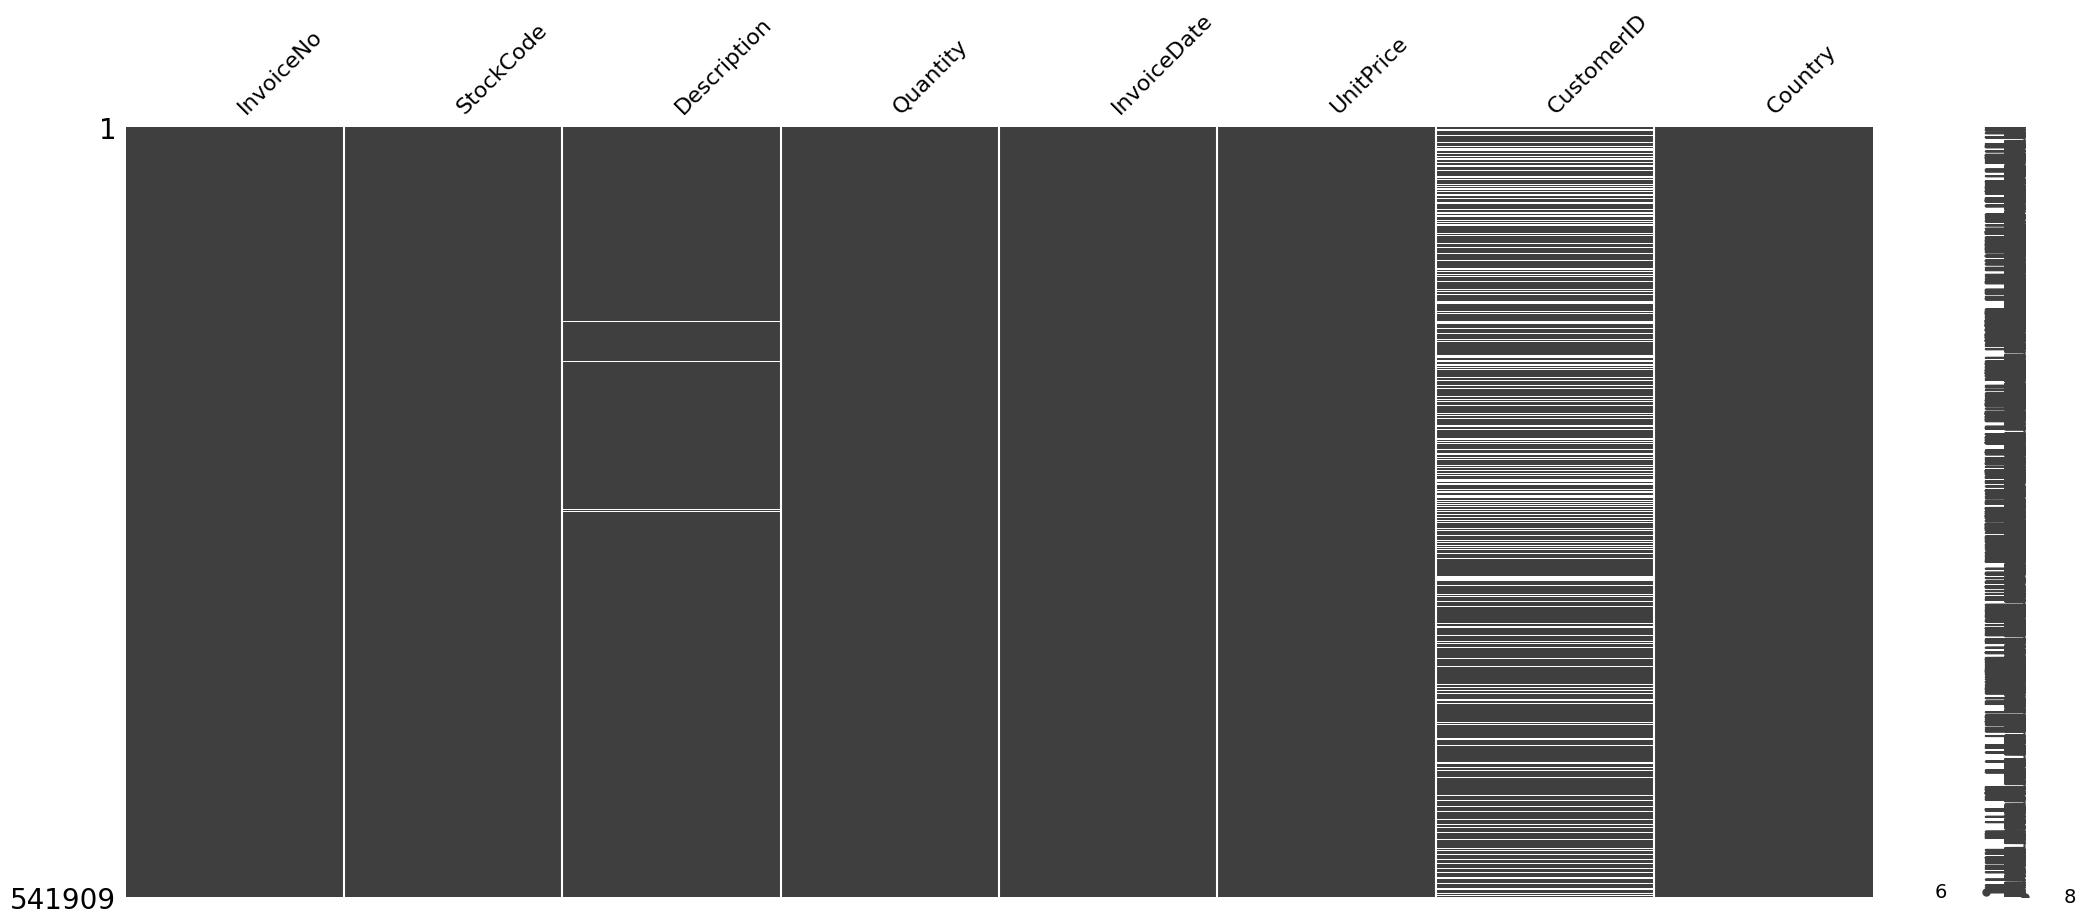

In [25]:
# Resumindo os dados que estão faltando, no formato de Gráfico
msno.matrix(df);

In [47]:
# Resumindo os dados que estão faltando, no formato de tabela
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [48]:
# FILTRANDO PARA VALORES NÃO NULOS
df = df[~df['CustomerID'].isna()]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [49]:
#Verificando se ainda há valores faltantes
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0



## *Dados Duplicados*
Remoção de dados dos dados duplicados, pois não tem sentido duas compras do mesmo cliente no mesmo horários.

In [51]:
# Identificar quantos valores duplicados há em cada duplicata
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
 .head(10)
)


n_duplicates
InvoiceNo StockCode Description                         Quantity InvoiceDate      UnitPrice CustomerID Country                     
555524    22698     PINK REGENCY TEACUP AND SAUCER      1        6/5/2011 11:37   2.95      16923.0    United Kingdom            20
          22697     GREEN REGENCY TEACUP AND SAUCER     1        6/5/2011 11:37   2.95      16923.0    United Kingdom            12
572861    22775     PURPLE DRAWERKNOB ACRYLIC EDWARDIAN 12       10/26/2011 12:46 1.25      14102.0    United Kingdom             8
572344    M         Manual                              48       10/24/2011 10:43 1.50      14607.0    United Kingdom             6
540524    21756     BATH BUILDING BLOCK WORD            1        1/9/2011 12:53   5.95      16735.0    United Kingdom             6
541266    21754     HOME BUILDING BLOCK WORD            1        1/16/2011 16:25  5.95      15673.0    United Kingdom             6
          21755     LOVE BUILDING BLOCK WORD            1        1/16/2011 16:25  5.95      15673.0    United Kingdom             6
538514    21756     BATH BUILDING BLOCK WORD            1        12/12/2010 14:27 5.95      15044.0    United Kingdom             6
578289    23395     BELLE JARDINIERE CUSHION COVER      1        11/23/2011 14:07 3.75      17841.0    United Kingdom             6
550331    85202     HANGING WOOD AND FELT HEART         1        4/17/2011 13:43  0.42      15555.0    United Kingdom             5

In [59]:
df = df.drop_duplicates(keep='first')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


## Retirada de valores sem sentido
* Preços unitários iguais ou menores que zero
* Quantidade de Produtos iguais ou menores que zero

In [67]:
# Fazendo um filtro para retirar linhas com Preços unitários e
# Quantidade de Produtos menores ou iguais a zero:
condicao1 = df['UnitPrice'] > 0
condicao2 = df['Quantity'] > 0
df = df.loc[condicao1 & condicao2]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Correção do tipo de dados

In [69]:
df.InvoiceDate = df.InvoiceDate.astype('datetime64')
df.CustomerID = df.CustomerID.astype('int')

<ipython-input-69-781244725ec6>:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df.InvoiceDate = df.InvoiceDate.astype('datetime64')


# IDENTIFICAÇÃO/REMOÇÃO VALORES EXTREMOS (OUTLIERS)

<Axes: >

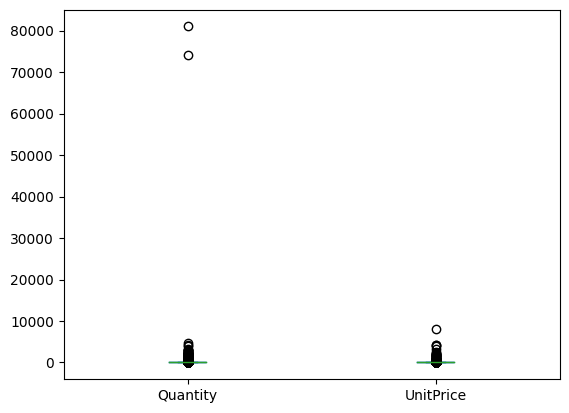

In [76]:
#Gráfico BoxPlot para identificação de Outliers. Não tem sentido aplicar no código do cliente.
df[['Quantity','UnitPrice']].plot.box()



In [78]:
# Cliente pediu para retirar os valores extremos as seguir:
condicao1 = df['UnitPrice'] <= 5000
condicao2 = df['Quantity'] <= 10000
df = df.loc[condicao1 & condicao2]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


<Axes: >

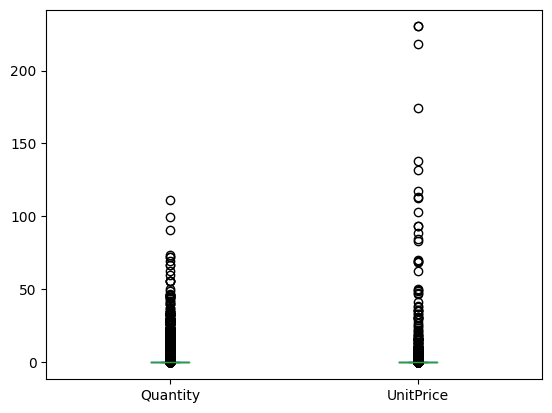

In [81]:
# Box plot com dados padronizados
df[['Quantity','UnitPrice']].apply(scale).plot.box()

# ALGUMAS MÉTRICAS

In [85]:
# TOTAL DA COMPRA
df['Valor Total da Compra'] = df['Quantity']*df['UnitPrice']
df.head()

<ipython-input-85-af12b082f6a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Valor Total da Compra'] = df['Quantity']*df['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Valor Total da Compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [87]:
# Data da última compra
DataMax = df.InvoiceDate.max()
print(DataMax)

2011-12-09 12:50:00
